In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#Get path to data and create a data frame with summary analytics

path = 'archive/train.csv'

raw_data = pd.read_csv(path)
print(raw_data.info())
print(raw_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44   

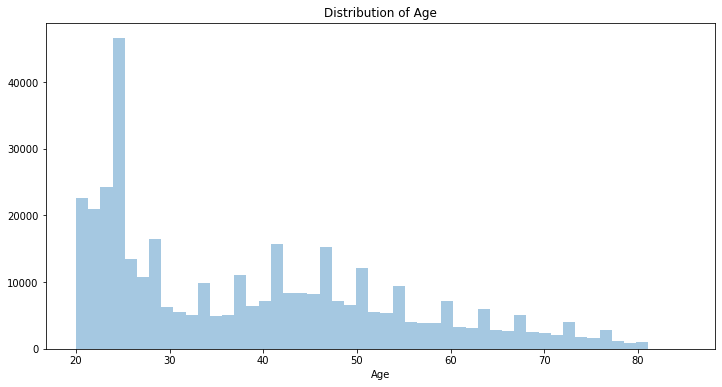

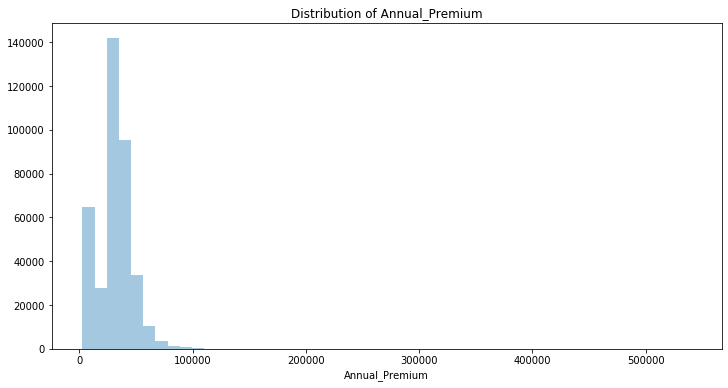

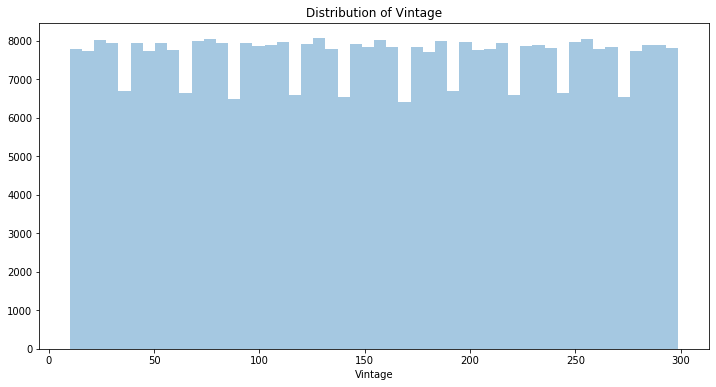

In [53]:
'''Based on our summary tables, we know that there is no missing data to worry about (nice!). First things first, we should
visualize the distributions of our continuous random variables Age, Annual_Premium, and Vintage'''

plt.figure(figsize=(12,6))
plt.title("Distribution of Age")
sns.distplot(a=raw_data['Age'], kde=False)

plt.figure(figsize=(12,6))
plt.title("Distribution of Annual_Premium")
sns.distplot(a=raw_data['Annual_Premium'], kde=False)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Distribution of Vintage")
sns.distplot(a=raw_data['Vintage'], kde=False)
plt.show()

C:\Users\colin\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


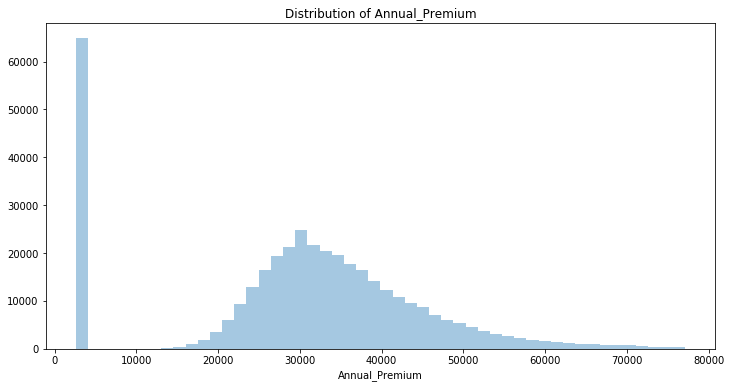

In [55]:
'''
Based on the results of our exploratory analysis on Age, Annual_Premium, and Vintage, we can conclude the following:
    1: Age is approximately bimodal in distribution.
    2: Annual Premium looks approximately normally distributed, but there are likely outliers that should be dealt with
    3: Vintage looks relatively uniform in the data set.
    
The first thing we should do is address 2, and find and remove outliers in the Annual_Premium attribute, replacing them
with the mean Annual_Premium. We will define outliers as those data points > 3 std away from the mean.
'''


def replace(group):
    mean, std = group.mean(), group.std()
    outliers = abs((group - mean)) > 3*std
    group[outliers] = mean       
    return group

plt.figure(figsize=(12,6))
plt.title("Distribution of Annual_Premium")
sns.distplot(a=raw_data['Annual_Premium'].transform(replace), kde=False)
plt.show()

C:\Users\colin\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


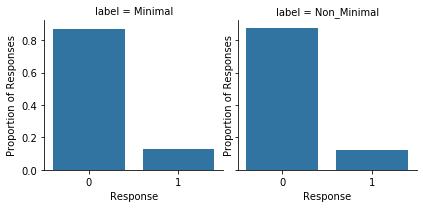

In [100]:
'''
Based on what we get when we analyze Annual_Premium with outliers removed, there is a hidden "feature" in the data. Many
customers are paying a minimum premium. This could be a situation where we can introduce a new feature. We should see if
there is a clear impact of minimum payment on customer response.
'''
#Get the value of the minimal premium
mode = raw_data['Annual_Premium'].mode()

#Calculate ratio of responses for customers paying the minimal premium
minimal_data = raw_data[['Annual_Premium', 'Response']].loc[raw_data['Annual_Premium'] == int(mode)].groupby("Response").count()
minimal_rat = minimal_data / minimal_data.sum()
minimal_rat['label'] = 'Minimal'

#Calculate ratio of responses for customers not paying the minimal premium
nonmin_data = raw_data[['Annual_Premium', 'Response']].loc[raw_data['Annual_Premium'] != int(mode)].groupby("Response").count()
nonmin_rat = nonmin_data / nonmin_data.sum()
nonmin_rat['label'] = 'Non_Minimal'

#Concatenate dataframes to use facetgrid
rat_data = pd.concat([minimal_rat, nonmin_rat]).reset_index()
grid = sns.FacetGrid(rat_data, col='label')
grid.map(sns.barplot, 'Response', 'Annual_Premium').set(ylabel='Proportion of Responses')

#Conclusion: There does not seem to be any relationship between type of premium (minimal or non-minimal) and response.

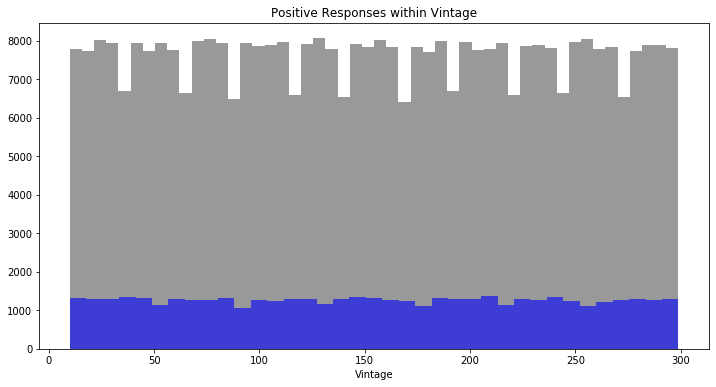

In [57]:
'''
We now turn our attention to vintage. We should see if there is a clear relationship between Vintage and Response. We can
visualize this relationship by comparing the proportion of each response within vintage.
'''

Series1 = raw_data['Vintage'].loc[raw_data['Response'] == 1]

plt.figure(figsize=(12,6))
plt.title('Positive Responses within Vintage')
bottom_plt = sns.distplot(a=tr_data['Vintage'], kde=False, color="black")
top_plt = sns.distplot(a=Series1, kde=False, color='blue', hist_kws=dict(alpha=.6))
plt.show()


#Conclusion: These data suggest response is relatively unaffected by Vintage.

Text(0.5, 0, 'Age')

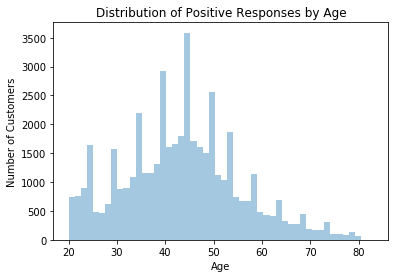

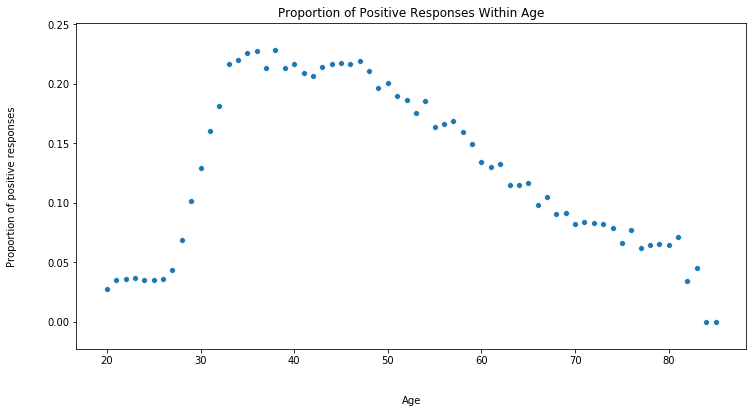

In [76]:
'''
Now we must turn our attention to Age. We can visualize the relationship between age and response similarly to vintage.
However, Vintage was approximately uniform whereas age is not, so we should visualize response as a proportion in this case.
'''
#Visualize the distribution of positive responses by age.
pos_response = raw_data.loc[raw_data['Response']==1]
sns.distplot(a=pos_response['Age'], kde=False).set(ylabel='Number of Customers', title='Distribution of Positive Responses by Age')

#Get all the responses from Age that were positive and group by age, then the total number of responses grouped by age
age_pos = raw_data[['Age','Response']].loc[raw_data['Response'] == 1].groupby('Age').count()
age_tot = raw_data[['Age','Response']].groupby('Age').count()

#Divide the number of positive responses by the total number of responses to get a percentage
age_pos_adj = age_pos/age_tot
age_pos_adj = age_pos_adj.fillna(0) #fill in null values as a result of dividing by zero.


plt.figure(figsize=(12,6))
plt.title('Proportion of Positive Responses Within Age')
bottom_plt = sns.scatterplot(x=age_pos_adj.index, y=age_pos_adj['Response'])
plt.ylabel('Proportion of positive responses', labelpad=30)
plt.xlabel('Age', labelpad=30)

#Conclusion: The probability that a customer will respond positively does respond to Age relatively strongly
#compared to the other variables we have investigated and is maximal around 30-50 years old.

In [60]:
'''We will now move on to preparing data to train a RandomForestClassifier.'''

#We have three variables which have string values: Gender, Vehicle_Age, and Vehicle_Damage
#We want to see what values these variables take
obj_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

for col in obj_cols:
    print(raw_data[col].unique())
    
#Because we have few unique string values we can One-Hot encode these variables.
from sklearn.preprocessing import OneHotEncoder

#Initialize OneHotEncoder and apply to data
hot_code = OneHotEncoder(sparse=False, handle_unknown='ignore')
OH_raw_data = pd.DataFrame(hot_code.fit_transform(raw_data[obj_cols]))
OH_raw_data.columns = hot_code.get_feature_names(obj_cols)

#Restore index on raw_data
OH_raw_data.index = raw_data.index

#Get strictly numerical data from raw_data
num_data = raw_data.drop(obj_cols, axis=1)

#Concatenate OH data with numerical data to complete initial preprocessing and split target data
processed_data = pd.concat([OH_raw_data, num_data], axis=1)
X = processed_data.drop(['Response'], axis=1)
y = processed_data.Response

print(OH_raw_data)

['Male' 'Female']
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']
        Gender_Female  Gender_Male  Vehicle_Age_1-2 Year  \
0                 0.0          1.0                   0.0   
1                 0.0          1.0                   1.0   
2                 0.0          1.0                   0.0   
3                 0.0          1.0                   0.0   
4                 1.0          0.0                   0.0   
...               ...          ...                   ...   
381104            0.0          1.0                   1.0   
381105            0.0          1.0                   0.0   
381106            0.0          1.0                   0.0   
381107            1.0          0.0                   0.0   
381108            0.0          1.0                   1.0   

        Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years  Vehicle_Damage_No  \
0                        0.0                    1.0                0.0   
1                        0.0                    0.0             

In [61]:
#Break data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=1)

In [62]:
#Import initial model and basic metrics
import graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae, accuracy_score

#Initialize model
cross_sell_model = RandomForestClassifier(random_state=1, n_estimators=20)

#Train model
cross_sell_model.fit(X_train, y_train)

#Check initial performance on validation set
model_predictions = cross_sell_model.predict(X_valid)

print('Mean Absolute Error: ' + str(mae(y_valid, model_predictions)) + '\n' 
      + 'Accuracy Score: ' + str(accuracy_score(y_true=y_valid, y_pred=model_predictions)))


#So with very basic preprocessing we have a model which is performing at around 87% accuracy.

Mean Absolute Error: 0.12859804255989085
Accuracy Score: 0.8714019574401092


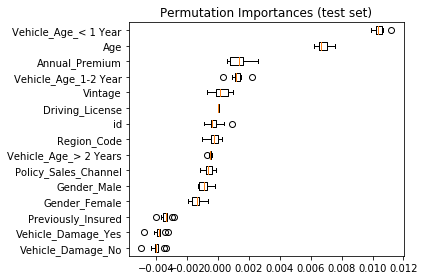

In [63]:
'''
We can visualize which features in our data are most important for model predictions
by utilizing permutation importance.
'''
from sklearn.inspection import permutation_importance

#Visualize feature importance
result = permutation_importance(cross_sell_model, X_valid, y_valid, n_repeats=10,
                                random_state=1, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_valid.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#The first thing to note about feature importances is that the permutation of each feature affects accuracy of
#our model prediction by at most one percent. This would suggest that correlations which exist between any one of
#our independent variables and customer response are quite low. That being said, the two most important features
#are having a vehicle less than 1 year old, and the age of the customer.

C:\Users\colin\anaconda3\lib\site-packages\seaborn\axisgrid.py:388: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\colin\anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


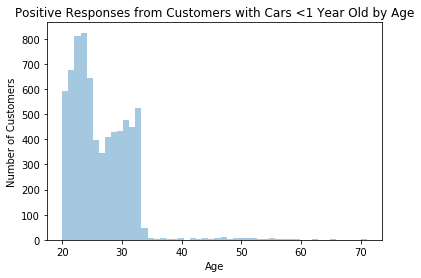

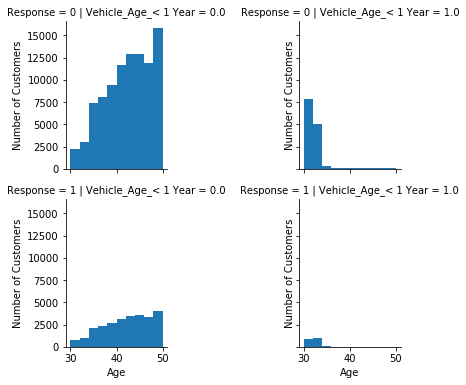

In [99]:
'''
Given the results of feature permutation, we should investigate 'Vehicle_Age_< 1 Year' and how that variable predicts response.
Visualizing that variable with respect to Age (our second most important feature) reveals something powerful. Customers with 
cars <1 year old are highly NOT likely to want car insurance from the company. Previous analyses showed that customers in the
30-50 Age range are most likely to respond in the affirmative, and very few customers within this age range have new vehicles.
'''

hypothesis_slice = processed_data.loc[(processed_data['Vehicle_Age_< 1 Year']==1) & (processed_data['Response']==1)]
sns.distplot(a=hypothesis_slice['Age'], kde=False).set(ylabel='Number of Customers', 
                                                       title='Positive Responses from Customers with Cars <1 Year Old by Age')

hypothesis_slice2 = processed_data.loc[(processed_data['Vehicle_Age_< 1 Year']==1) & (processed_data['Response']==0)]

age_range_pos = processed_data.loc[(processed_data['Age']<=50) & (processed_data['Age']>=30)]

grid = sns.FacetGrid(age_range_pos, col='Vehicle_Age_< 1 Year', row='Response', gridspec_kws={"wspace":1.3})
grid.map(plt.hist, 'Age').set(ylabel='Number of Customers')

#A glance at the last row of our facet grid demonstrates the strength of the impact of car age on customer response.

In [ ]:
'''
Conclusions: Customers between the ages of 30-50 with cars older than 1 year are the most likely to respond in the affirmative.
This could be reflective of several posibilities. First, it could be that people in the 30-50 age range are least satisfied with
their car insurance companies and are most likely to switch. Second, it could be that first time car buyers <30 years old are still
on their parents car insurance, meaning that they don't have the ability to switch providers. Additionally, customers over 50 may
be used to their insurer and have no desire to reenter the car insurance market. Of these two hypotheses I believe the second to 
be most likely.
'''